In [1]:
def numToLabel(num):
    labels = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
    return labels[num]

def labelToNum(label):
    labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
    return labels[label]

In [33]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

bt_collection = os.getcwd() + '/datasets/brain_tumor_collection/processed/test/'
kaggle_collection = os.getcwd() + '/datasets/kaggle/processed/test'
hf_collection = os.getcwd() + '/datasets/MRI-Images-of-Brain-Tumor/processed/test/'
combined = os.getcwd() + '/datasets/combined/test'

train_data_gen = ImageDataGenerator(rescale=1./255)

bt_train_gen = train_data_gen.flow_from_directory(bt_collection, target_size=(200, 200), batch_size=20, class_mode='categorical')
kaggle_train_gen = train_data_gen.flow_from_directory(kaggle_collection, target_size=(200, 200), batch_size=20, class_mode='categorical')
hf_train_gen = train_data_gen.flow_from_directory(hf_collection, target_size=(200, 200), batch_size=20, class_mode='categorical')
combined = train_data_gen.flow_from_directory(combined, target_size=(200, 200), batch_size=20, class_mode='categorical')

Found 394 images belonging to 4 classes.


Found 1311 images belonging to 4 classes.
Found 537 images belonging to 4 classes.
Found 2242 images belonging to 4 classes.


In [3]:
from tensorflow.keras.models import load_model

model = load_model('final_model.h5')

2024-04-13 22:33:42.438992: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 22:33:42.458436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 22:33:42.458487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 22:33:42.462526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 22:33:42.462580: I external/local_xla/xla/stream_executor

1/1 [==============================] - 1s 652ms/step


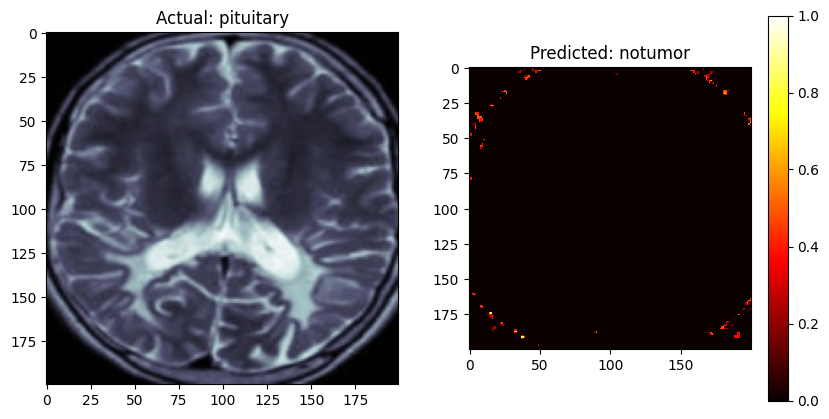

1/1 [==============================] - 0s 26ms/step


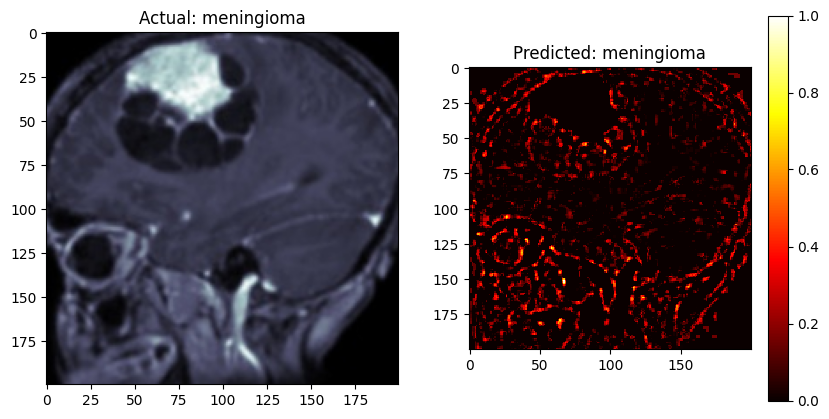

1/1 [==============================] - 0s 25ms/step


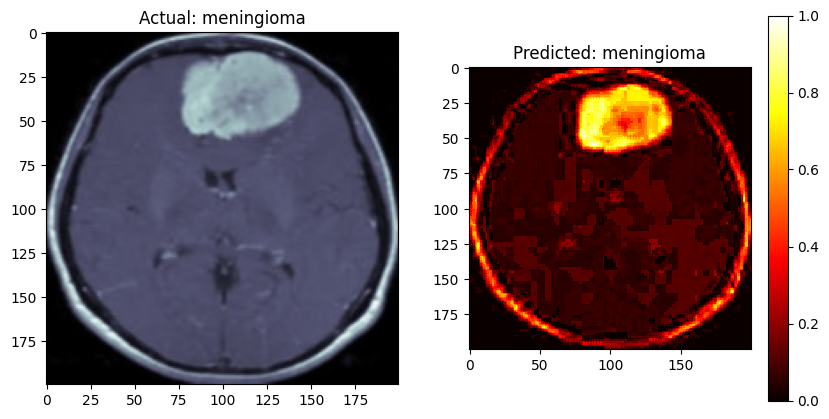

1/1 [==============================] - 0s 27ms/step


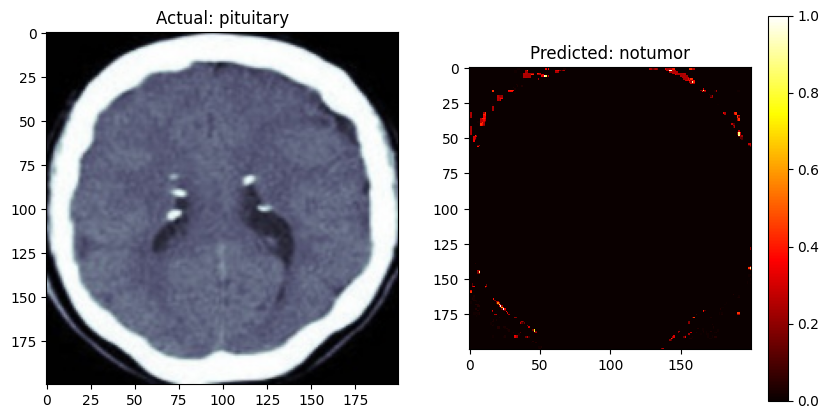

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np

# Load the model
model = tf.keras.models.load_model('final_model.h5')
last_conv_layer = model.get_layer('conv5_block3_out')

# Get a batch of images and labels

for i in range(4):
    images, labels = next(bt_train_gen)
    image = np.expand_dims(images[0], axis=0)
    label = labels[0]

    preds = model.predict(image)
    pred_class = np.argmax(preds[0])

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer(image)
        tape.watch(last_conv_layer_output)
        
        preds = model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Draw image
    axs[0].imshow(images[0], cmap='gray')
    axs[0].set_title("Actual: " + numToLabel(np.argmax(label)))


    # Draw heatmap
    im = axs[1].imshow(heatmap, cmap='hot', interpolation='nearest')
    axs[1].set_title("Predicted: " + numToLabel(pred_class))

    # Add a colorbar
    fig.colorbar(im, ax=axs[1])
    plt.show()
    
